In [47]:
import os
import random

import numpy as np

from rfft.hypothesis import Hypothesis
from rfft.multilayer_perceptron import MultilayerPerceptron

from decoy_mnist import generate_dataset
from decoy_mnist import load_annotations
from decoy_mnist import load_hypothesis

In [4]:
Xr, X, y, E, Xtr, Xt, yt, Et = generate_dataset()

In [5]:
dirname = 'tagging/decoy_mnist'

In [6]:
def score_model(mlp):
    print('Train: {0}, Test: {1}'.format(mlp.score(X, y), mlp.score(Xt, yt)))
    return (mlp.score(X, y), mlp.score(Xt, yt))

In [43]:
def run_experiment():
    INCREMENT = 5
    WEIGHT_PER_MASK = 1000
    
    xml_files = [os.path.join(dirname, x) for x in os.listdir(dirname) if x.endswith('.xml')]
    random.shuffle(xml_files)
    
    accuracies = []

    iteration = 0
    for indices, hypothesis in Hypothesis.incrementally_sample(xml_files,
                                                               load_hypothesis,
                                                               X.shape,
                                                               increment=INCREMENT):
        non_zero_rows = np.where(hypothesis.A != 0)[0]
        assert set(non_zero_rows) == set(indices)
        assert(len(indices) == iteration * INCREMENT)
        
        hypothesis.weight = WEIGHT_PER_MASK * len(indices)
        mlp = MultilayerPerceptron()
        mlp.fit(X,
                y,
                hypothesis=hypothesis,
                num_epochs=6,
                always_include=indices,
                show_progress_every=500,
                verbose=True)

        train_acc, test_acc = score_model(mlp)
        accuracies.append((len(indices), train_acc, test_acc))
        iteration += 1
    return accuracies

In [11]:
all_accuracies = []

In [44]:
for i in range(1):
    all_accuracies.append(run_experiment())

Iteration=1000, crossentropy=33.3528227687, rightreasons=0.0, smallparams=0.0361458817879, lenX=1.0Train: 0.97075, Test: 0.6292
Iteration=1000, crossentropy=426.619269586, rightreasons=227.187182571, smallparams=0.0374157827702, lenX=1.0Train: 0.866883333333, Test: 0.7596
Iteration=1000, crossentropy=1146.19934444, rightreasons=860.235774012, smallparams=0.0361971850174, lenX=1.0Train: 0.6295, Test: 0.5455
Iteration=1000, crossentropy=1479.41457456, rightreasons=2154.62797238, smallparams=0.0356430746285, lenX=1.0Train: 0.3178, Test: 0.299
Iteration=1000, crossentropy=1729.7274119, rightreasons=1517.99976542, smallparams=0.0348106239013, lenX=1.0Train: 0.391183333333, Test: 0.3388
Iteration=1000, crossentropy=2964.0140936, rightreasons=3700.32144905, smallparams=0.0367563252424, lenX=1.0Train: 0.301933333333, Test: 0.2732
Iteration=1000, crossentropy=3084.5038819, rightreasons=16342.3353348, smallparams=0.0349767956356, lenX=1.0Train: 0.14895, Test: 0.1424
Iteration=1000, crossentropy=

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import spline

/home/atithi/lime/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


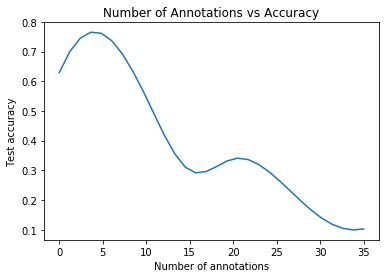

In [54]:
accuracies = np.array(list(map(list, all_accuracies[1])))
xnew = np.linspace(accuracies[:, 0].min(), accuracies[:, 0].max(), 30)
power_smooth = spline(np.array(accuracies[:, 0]), np.array(accuracies[:, 2]), xnew)
plt.title('Number of Annotations vs Accuracy')
plt.xlabel('Number of annotations')
plt.ylabel('Test accuracy')
plt.plot(xnew, power_smooth)
plt.show()